In [1]:
from math import log

# 计算信息熵
def compute_entropy(dataset):
    # 求总样本数
    num_of_examples = len(dataset)
    labelCnt = {}
    # 遍历整个样本集合
    for example in dataset:
        # 当前样本的标签值是该列表的最后一个元素
        currentLabel = example[-1]
        # 统计每个标签各出现了几次
        if currentLabel not in labelCnt.keys():
            labelCnt[currentLabel] = 0
        labelCnt[currentLabel] += 1
    entropy = 0.0
    # 对于原样本集，labelCounts = {'no': 6, 'yes': 9}
    # 对应的初始shannonEnt = (-6/15 * log(6/15)) + (- 9/15 * log(9/15))
    for key in labelCnt:
        p = labelCnt[key] / num_of_examples
        entropy -= p * log(p, 2)
    return entropy

# 提取子集合
# 功能：从dataSet中先找到所有第axis个标签值 = value的样本
def create_sub_dataset(dataset, index, value):
    sub_dataset = []
    for example in dataset:
        current_list = []
        if example[index] == value:
            current_list = example[:index]
            current_list.extend(example[index + 1 :])
            sub_dataset.append(current_list)
    return sub_dataset

def choose_best_feature(dataset):
    num_of_features = len(dataset[0]) - 1
    current_entropy = compute_entropy(dataset)

    best_information_gain_ratio = 0.0
    index_of_best_feature = -1

    for i in range(num_of_features):
        # 构造所有样本在当前特征的取值的列表
        values_of_current_feature = [example[i] for example in dataset]
        unique_values = set(values_of_current_feature)
        # 初始化的条件信息熵
        new_entropy = 0.0
        split_info = 0.0

        for value in unique_values:
            sub_dataset = create_sub_dataset(dataset, i, value)
            p = len(sub_dataset) / len(dataset)
            # 计算使用该特征进行样本划分后的条件信息熵
            new_entropy += p * compute_entropy(sub_dataset)
            # print(new_entropy)
            # 计算分离信息熵
            split_info -= p * log(p, 2)
            # print(split_info)
        # 计算信息增益
        # information_gain = current_entropy - new_entropy
        # 计算信息增益率（Gain_Ratio = Gain / Split_Info）
        information_gain_ratio = (current_entropy - new_entropy) / split_info
        # 求出最大的信息增益及对应的特征下标
        if information_gain_ratio > best_information_gain_ratio:
            best_information_gain_ratio = information_gain_ratio
            index_of_best_feature = i
    # 这里返回的是特征的下标
    return index_of_best_feature

# 返回具有最多样本数的那个标签的值（'yes' or 'no'）
def find_label(classList):
    # 初始化统计各标签次数的字典
    # 键为各标签，对应的值为标签出现的次数
    labelCnt = {}
    for key in classList:
        if key not in labelCnt.keys():
            labelCnt[key] = 0
        labelCnt[key] += 1
    # 将classCount按值降序排列
    # 例如：sorted_labelCnt = {'yes': 9, 'no': 6}
    sorted_labelCnt = sorted(labelCnt.items(), key = lambda a:a[1], reverse = True)
    # 下面这种写法有问题
    # sortedClassCount = sorted(labelCnt.iteritems(), key=operator.itemgetter(1), reverse=True)
    # 取sorted_labelCnt中第一个元素中的第一个值，即为所求
    return sorted_labelCnt[0][0]

def create_decision_tree(dataset, features):
    # 求出训练集所有样本的标签
    label_list = [example[-1] for example in dataset]
    
    """ 递归结束的条件：若当前集合的所有样本标签相等（即样本已被分“纯”）
   直接返回该标签值作为一个叶子节点 """    
    if label_list.count(label_list[0]) == len(label_list):
        return label_list[0]
    # 若训练集的所有特征都被使用完毕，当前无可用特征
    if len(dataset[0]) == 1:
        return find_label(label_list)
    # 获到最佳特征
    index_of_best_feature = choose_best_feature(dataset)    
    best_feature = features[index_of_best_feature]

    # 初始化决策树
    decision_tree = {best_feature: {}}
    # 使用过当前最佳特征后将其删去
    del(features[index_of_best_feature])
    # 取出各样本在当前最佳特征上的取值列表
    values_of_best_feature = [example[index_of_best_feature] for example in dataset]
    # 用set()构造当前最佳特征取值的不重复集合
    unique_values = set(values_of_best_feature)
    # 对于uniqueVals中的每一个取值
    for value in unique_values:
        # 子特征 = 当前特征（因为刚才已经删去了用过的特征）
        sub_features = features[:]
        # 递归调用create_decision_tree去生成新节点
        decision_tree[best_feature][value] = create_decision_tree(create_sub_dataset(dataset, index_of_best_feature, value), sub_features)
    return decision_tree

# 加载数据集
def get_dataset():
    fr = open('youn.txt',encoding='utf-8')
    dataset = [inst.strip().split('  ') for inst in fr.readlines()]
    #print(dataset)
    features = ['年龄','有工作','有住房','信用']
    return dataset, features

# 用上面训练好的决策树对新样本分类
def classify(decision_tree, features, test_example):
    # 根节点代表的属性
	first_feature = list(decision_tree.keys())[0]
    # second_dict是第一个分类属性的值（也是字典）
	second_dict = decision_tree[first_feature]
    # 树根代表的属性，所在属性标签中的位置，即第几个属性
	index_of_first_feature = features.index(first_feature)  
    # 对于second_dict中的每一个key
	for key in second_dict.keys():
		if test_example[index_of_first_feature] == key:
            # 若当前second_dict的key的value是一个字典
			if type(second_dict[key]).__name__ == 'dict':
                # 则需要递归查询
				classLabel = classify(second_dict[key], features, test_example)
            # 若当前second_dict的key的value是一个单独的值
			else:
                # 则就是要找的标签值
				classLabel = second_dict[key]
	return classLabel

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = [u'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
decisionNode = dict(boxstyle='sawtooth',fc='0.8')
leafNode = dict(boxstyle='round4',fc='0.8')
arrow_args = dict(arrowstyle='<-')
# 使用文本注解绘制树节点
def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    """绘制带箭头的节点"""
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',xytext= centerPt,textcoords='axes fraction',va='center',ha='center',bbox=nodeType,arrowprops=arrow_args)

def createPlot():
    """绘制树节点"""
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111,frameon=False)
    plotNode('决策节点',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode('叶节点',(0.8,0.1),(0.3,0.8),leafNode)
    plt.show()

def getNumLeafs(myTree):
    """获取叶节点的数目"""
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    """获取树的层数"""
    maxDepth = 0
    firstStr =list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ =='dict':
            thisDepth = 1+getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

def plotMidText(cntPt,parentPt,txtString):
    """在父子节点间填充文本信息"""
    xMid = (parentPt[0]-cntPt[0])/2+cntPt[0]
    yMid = (parentPt[1]-cntPt[1])/2+cntPt[1]
    createPlot.ax1.text(xMid,yMid,txtString)

def plotTree(myTree,parentPt,nodeTxt):
    """绘制树形图"""
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1 + float(numLeafs))/2/plotTree.totalW,plotTree.yOff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff-1/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1/plotTree.totalW
            plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),cntrPt,leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
    plotTree.yOff = plotTree.yOff + 1 / plotTree.totalD

def createPlot(inTree):
    """创建绘图区"""
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    axprops = dict(xticks=[],yticks=[])
    createPlot.ax1 = plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()


{'有住房': {'是': '是', '否': {'有工作': {'是': '是', '否': '否'}}}}

 是


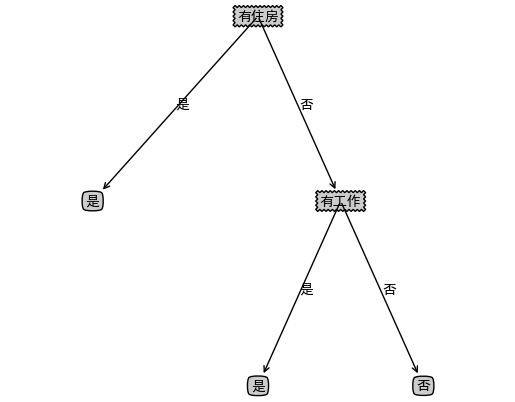

In [2]:
dataset, features = get_dataset()
decision_tree = create_decision_tree(dataset, features)
# 打印生成的决策树
print(decision_tree)
# 对新样本进行分类测试
features = ['年龄','有工作','有住房','信用']
test_example = ['中年', '是', '否', '非常好']
print('\n',classify(decision_tree, features, test_example))
createPlot(decision_tree) 